In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)

### a bunch of utils

In [3]:
def get_data(data_files):
    
    """
    given a list of paths to pandas files having same columns, reads them in
    
    """
    # read in all the dfs
    df_list = []
    for fname in data_files:
        df_list.append(pd.read_csv(fname))
        
    # merge rows of all the dfs
    df = pd.concat(df_list)
    
    # drop columns with all nan
    df = df.dropna(axis='columns',how='all')
    
    return df


def merge(report,camp):
    """
    merges report and camp on Ad ID
    
    """
    
    def homogenise(a):
        if str(a) == "nan":
            return 0
        else:
            return int(a.split(":")[1])
    
    
    # camp has a weird formatting compared to report. homogenise them...
    camp['Ad ID'] = camp['Ad ID'].apply(homogenise)
    
    # merge on Ad ID
    ad_data = report.merge(camp, on="Ad ID")
    # remove duplicate columns
    ad_data = ad_data.loc[:,~ad_data.columns.duplicated()]
    
    return ad_data

In [4]:
campaign_files = ["data/campaign_info_1-200.csv","data/campaign_info_201-316.csv"]
campaign = get_data(campaign_files)

/Users/arvind/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (35,42,49,105,107,110,116,117,128,129,136,151,153,173,193,232,233,238,241,242,245,246,249,250,253,278,280,287,289,290,292,293,294,296,297,298,300,301,329,336,360,541,547) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/arvind/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (13,22,35,39,42,46,105,108,116,117,118,119,128,129,131,133,137,142,145,151,153,173,174,175,193,231,232,233,237,238,239,241,242,243,245,246,249,250,253,254,257,258,261,278,280,281,283,287,288,289,290,291,292,293,294,295,296,297,298,300,301,302,304,305,306,308,309,310,312,313,314,316,318,320,345,364,430,431,432,433,434,440,441,442,443,444,450,451,452,453,454,460,461,462,463,470,471,472,473,541,547) have mixed types.Specify dtype option on import or set low_memory=F

In [5]:
report_files = ["data/metrics_info_1-200.csv","data/metrics_info_201-316.csv"]
report = get_data(report_files)

In [6]:
ad_data = merge(report, campaign)

In [7]:
sorted(ad_data.columns)

['Ad Delivery',
 'Ad ID',
 'Ad Name_x',
 'Ad Name_y',
 'Ad Set Bid Strategy',
 'Ad Set Budget',
 'Ad Set Budget Type',
 'Ad Set Daily Budget',
 'Ad Set Delivery',
 'Ad Set ID_x',
 'Ad Set ID_y',
 'Ad Set Lifetime Budget',
 'Ad Set Lifetime Impressions',
 'Ad Set Maximum Spend Limit',
 'Ad Set Minimum Spend Limit',
 'Ad Set Name_x',
 'Ad Set Name_y',
 'Ad Set Run Status',
 'Ad Set Time Start',
 'Ad Set Time Stop',
 'Ad Status',
 'Add End Card',
 'Additional Body 1',
 'Additional Body 1 Placement',
 'Additional Custom Tracking Specs',
 'Additional Image 1 Crops',
 'Additional Image 1 Hash',
 'Additional Image 1 Placement',
 'Additional Image 2 Hash',
 'Additional Image 2 Placement',
 'Additional Image 3 Hash',
 'Additional Image 3 Placement',
 'Additional Image 4 Hash',
 'Additional Image 4 Placement',
 'Additional Image 5 Hash',
 'Additional Image 5 Placement',
 'Additional Video 1 Customization',
 'Additional Video 1 ID',
 'Additional Video 1 Placement',
 'Additional Video 1 Thumbnail 

In [8]:
# collection of different columns split here for ease of access
# don't be alarmed by the _x in some names, it just means we had them in both report and campaign csv!

metric_cols = ['Website Purchases','Website Purchase ROAS (Return on Ad Spend)',
              'Clicks (All)','CPC (All) (USD)','CTR (All)','CPM (Cost per 1,000 Impressions) (USD)',
              'Cost per 1,000 People Reached (USD)', 'Amount Spent (USD)']

text_cols = ['Title', 'Body', 'Display Link','Link Description', 'Ad Set Name_x', 'Campaign Name_x']

video_play_cols = ['Video Plays at 25%', 'Video Plays at 50%', 'Video Plays at 75%',
              'ThruPlays', 'Video Average Play Time']
             
media_cols = ['Image Hash','Video Thumbnail URL']

meta_cols = ['Ad ID','Ad Name_x','Campaign ID_x','Ad Set ID_x','Starts','Ad Set Time Start','Ad Status','Ad Delivery','Reporting Ends']

feature_cols = ['Gender', 'Age Min', 'Age Max','Messenger Positions']

In [9]:
cols = metric_cols + text_cols + video_play_cols + media_cols + meta_cols + feature_cols

In [10]:
ad_data = ad_data[cols] # we have 32 columns now.

In [11]:
# inferring start year, month
ad_data['start_date'] = pd.to_datetime(ad_data['Starts'], format='%Y-%m-%d')
ad_data['start_month_yr'] = ad_data['start_date'].dt.to_period('M')
ad_data['start_month'] = ad_data['start_date'].dt.month
ad_data['start_yr'] = ad_data['start_date'].dt.year

In [12]:
# inferring media type
def get_media_type(name,im,vid):
    if "Video" in name:
        return "Video"
    elif "Static" in name:
        return "Image"
    elif "GIF" in name:
        return "GIF"
    else:
        if str(im) != "nan":
            return "Image"
        elif str(vid) != "nan":
            return "Video"
        else:
            return "UNK"
ad_data["media_type"] = ad_data.apply(lambda x: get_media_type(x['Ad Name_x'], x['Image Hash'], x['Video Thumbnail URL']), axis=1)
ad_data["media_type"].value_counts(dropna=False)

Image    10346
GIF       2880
Video     1257
UNK        322
Name: media_type, dtype: int64

# Causal data columns

- only 2020
- take a subset of ad sets that have a decent strength 
- features to match
    - start month
    - display link
    - gender target
    - messenger
    - campaign name
    - ad set name
    - text: body features - 3 ideas : tf-idf, topic models, word clusters
- outcome
    - ctr
- compare
    - media_type

In [13]:
causal_data = ad_data[ad_data["start_yr"]==2020]

In [14]:
causal_data.shape

(4289, 39)

In [18]:
causal_cols = ['CTR (All)', 
               'CPC (All) (USD)',
               'Display Link', 
               'Campaign Name_x', 
               'Ad Set Name_x', 
               'Body', 
               'Ad ID',
               'media_type',
               'start_month',
               'Gender',
               'Messenger Positions']

In [19]:
causal_data = causal_data[causal_cols]

In [20]:
replace_nans = lambda name: str(name) != "nan"
convert_nans = lambda name: str(name)

In [21]:
causal_data["Display Link"] = causal_data["Display Link"].apply(replace_nans)
causal_data["Messenger Positions"] = causal_data["Messenger Positions"].apply(replace_nans)

<ipython-input-21-af2f55143298>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data["Display Link"] = causal_data["Display Link"].apply(replace_nans)
<ipython-input-21-af2f55143298>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data["Messenger Positions"] = causal_data["Messenger Positions"].apply(replace_nans)


In [22]:
# convert gender to categorical
gender_map = dict(zip(causal_data["Gender"].astype("category").cat.codes, causal_data["Gender"]))
causal_data["Gender"] = causal_data["Gender"].astype("category").cat.codes
print(gender_map)

{0: 'All', -1: nan, 2: 'Women', 1: 'Men'}


<ipython-input-22-00d350b229a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data["Gender"] = causal_data["Gender"].astype("category").cat.codes


In [23]:
# convert campaign name to categorical
campaign_Name_x_map = dict(zip(causal_data["Campaign Name_x"].astype("category").cat.codes, causal_data["Campaign Name_x"]))
causal_data["Campaign Name_x"] = causal_data["Campaign Name_x"].astype("category").cat.codes
print(campaign_Name_x_map)

{0: 'DR_Holiday 2020', 8: 'DR_Promotions_4', 10: 'DR_Skin Consultation', 1: 'DR_Kit Acquisition_Acne', 2: 'DR_Kit Acquisition_RLR', 3: 'DR_Kit Acquisition_RSG', 6: 'DR_Product_Retinol 14D Challenge', 4: 'DR_New Customer Exclusive_2020', 5: 'DR_Product_2020', 9: 'DR_Promotions_Prospecting', 7: 'DR_Promotions_3'}


<ipython-input-23-111247b6648b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data["Campaign Name_x"] = causal_data["Campaign Name_x"].astype("category").cat.codes


In [24]:
# inferring retargeting or prospecting

def ret_pro(name):
    if "Retargeting" in name:
        return 1
    elif "Prospecting" in name:
        return 0
    else:
        return -1
# a future step is to identify who they are prospecting and retargeting

causal_data["ret_pro"] = causal_data["Ad Set Name_x"].apply(ret_pro)
causal_data["ret_pro"].value_counts(dropna=False)

<ipython-input-24-f8de75467b81>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data["ret_pro"] = causal_data["Ad Set Name_x"].apply(ret_pro)


0    2654
1    1635
Name: ret_pro, dtype: int64

In [25]:
causal_data_notext = causal_data.drop(["Ad Set Name_x","Body"],axis=1)
causal_data_notext.rename(columns={'Ad ID':'id',
                            'CTR (All)':"ctr",
                            'CPC (All) (USD)': "cpc",
                            'Campaign Name_x':"campaign",
                            'Display Link':"link",
                            'Gender':"gender",
                            'Messenger Positions':"messenger"}, inplace=True)

In [26]:
causal_data_notext = causal_data_notext[causal_data_notext.media_type != "UNK"]
media_mapper = {"Image":0,"Video":1,"GIF":1}
causal_data_notext["media_type"] = causal_data_notext["media_type"].apply(media_mapper.get)
causal_data_notext["media_type"].value_counts(dropna=False)

0    2313
1    1960
Name: media_type, dtype: int64

In [27]:
causal_data_notext.to_csv("data/causal_notext.csv",index=False)

## Feature analysis

In [28]:
def ttest_binary(df_cons,feat_name,metric_name):

    df_media = df_cons[[metric_name, feat_name]]

    from scipy.stats import ttest_ind

    cat1 = df_cons[df_cons[feat_name]==True]
    cat2 = df_cons[df_cons[feat_name]==False]

    print(ttest_ind(cat1[metric_name], cat2[metric_name]))
    print("Class 1: ",cat1[metric_name].mean()," Length: ",len(cat1[metric_name]))
    print("Class 0: ",cat2[metric_name].mean()," Length: ",len(cat2[metric_name]))

    # get the means and t test. get the plot.
    plt.figure(figsize=(10, 5))
    ax = sns.boxenplot(x=feat_name, y=metric_name, data=df_media, showfliers=False)
    ax.set_title(metric_name)
    plt.show()

### retargeting, prospecting

Ttest_indResult(statistic=15.112172409138967, pvalue=2.6354028584762075e-50)
Class 1:  1.0496133223076924  Length:  1625
Class 0:  0.6287893226812682  Length:  2648


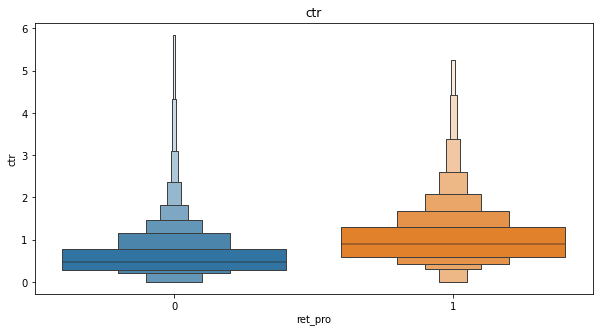

Ttest_indResult(statistic=9.032424431408913, pvalue=2.4902436510120053e-19)
Class 1:  1.9723838710769253  Length:  1625
Class 0:  1.5841783205211464  Length:  2648


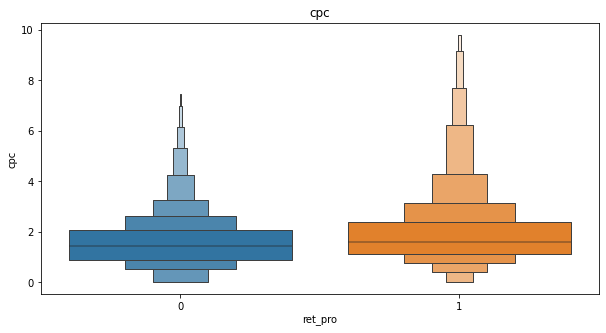

In [32]:
ttest_binary(causal_data_notext, "ret_pro", "ctr")
ttest_binary(causal_data_notext, "ret_pro", "cpc")

### display link

Ttest_indResult(statistic=-6.2783318382995486, pvalue=3.7630650640148204e-10)
Class 1:  0.7603106565171173  Length:  3856
Class 0:  1.052512910503598  Length:  417


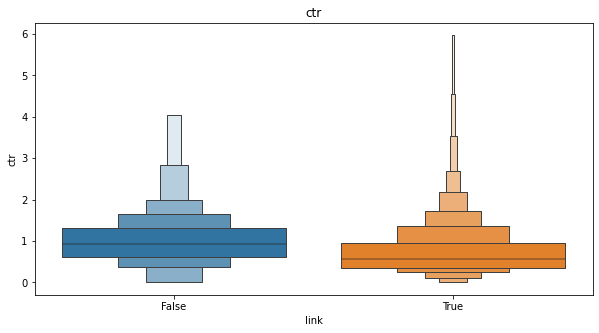

In [33]:
ttest_binary(causal_data_notext, "link", "ctr")

### media type

Ttest_indResult(statistic=10.344547821471545, pvalue=8.67126630662209e-25)
Class 1:  0.9428317888622462  Length:  1960
Class 0:  0.6583248893385202  Length:  2313


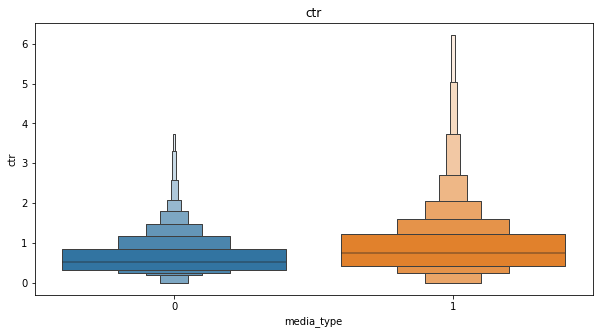

In [34]:
ttest_binary(causal_data_notext, "media_type", "ctr")

## quick analysis on retargeting vs prospective predictability

In [35]:
msk = np.random.rand(len(causal_data_notext)) < 0.8
train = causal_data_notext[msk]
test = causal_data_notext[~msk]

In [36]:
feature_cols_master = ['link', 'campaign', 'media_type', 'start_month','messenger','gender']

X_train = train.loc[:, feature_cols_master]
y_train = train.ret_pro
X_test = test.loc[:, feature_cols_master]
y_test = test.ret_pro

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

preds = logreg.predict(X_test)
acc_g = np.mean(preds==y_test)
print("Accuracy with gender: ",np.mean(preds==y_test))

Accuracy with gender:  0.9151162790697674


In [37]:
accs = []
for feat in feature_cols_master:
    feature_cols = [ff for ff in feature_cols_master if ff != feat]
    print(feature_cols)

    X_train = train.loc[:, feature_cols]
    y_train = train.ret_pro
    X_test = test.loc[:, feature_cols]
    y_test = test.ret_pro

    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    preds = logreg.predict(X_test)
    acc_wg = np.mean(preds==y_test)
    accs.append(acc_wg)
    print("Accuracy without {}: ".format(feat),np.mean(preds==y_test))

['campaign', 'media_type', 'start_month', 'messenger', 'gender']
Accuracy without link:  0.9151162790697674
['link', 'media_type', 'start_month', 'messenger', 'gender']
Accuracy without campaign:  0.8639534883720931
['link', 'campaign', 'start_month', 'messenger', 'gender']
Accuracy without media_type:  0.9151162790697674
['link', 'campaign', 'media_type', 'messenger', 'gender']
Accuracy without start_month:  0.9162790697674419
['link', 'campaign', 'media_type', 'start_month', 'gender']
Accuracy without messenger:  0.9197674418604651
['link', 'campaign', 'media_type', 'start_month', 'messenger']
Accuracy without gender:  0.7011627906976744


[Text(0, 0, 'all'),
 Text(1, 0, 'without link'),
 Text(2, 0, 'without campaign'),
 Text(3, 0, 'without media_type'),
 Text(4, 0, 'without start_month'),
 Text(5, 0, 'without messenger'),
 Text(6, 0, 'without gender')]

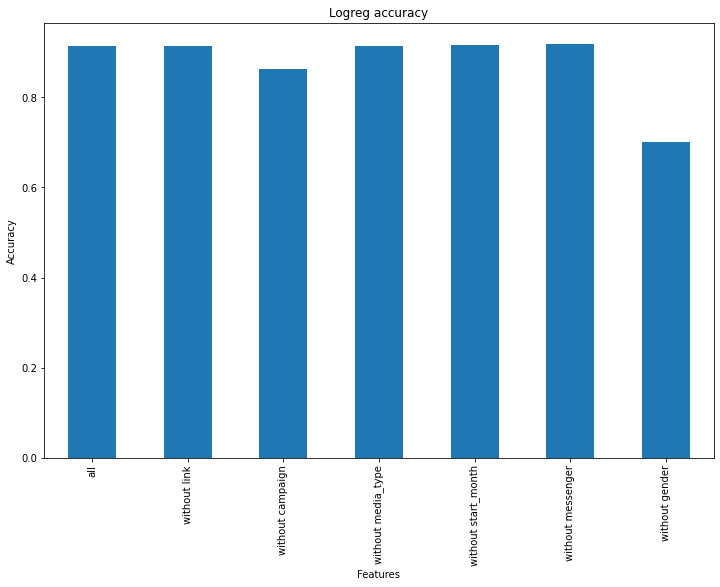

In [38]:
# Bring some raw data.
frequencies = [acc_g] + accs
# In my original code I create a series and run on that, 
# so for consistency I create a series from the list.
freq_series = pd.Series(frequencies)

x_labels = ["all"] + ["without %s" % i for i in feature_cols_master]

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Logreg accuracy')
ax.set_xlabel('Features')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(x_labels)

In [39]:
# gender is a cultprit - highly corelated with output
causal_data_notext['gender'].corr(causal_data_notext['ret_pro'])

-0.7614560070071145

# Text analysis

In [40]:
causal_data["Body"] = causal_data["Body"].apply(convert_nans)

<ipython-input-40-7b8edbcd3b4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data["Body"] = causal_data["Body"].apply(convert_nans)


In [41]:
# idea:

# a function that returns a domain vocabulary - ie words that significantly appear more frequently in these
# docs as compared to a general domain (could be english / or ads in general)

In [42]:
### questions in text
# using numbers
# length of text
# having domain words vs not
# having code vs not
# where is text in the image?

# visual
# color histogram
# background vs foreground
# model vs not

### body length and number of numerics

In [43]:
from nltk.tokenize import RegexpTokenizer
def get_counts(sent):
    sent = str(sent)
    tokenizer = RegexpTokenizer(r'\w+')
    sent_no_punc = tokenizer.tokenize(sent)
    return len(sent_no_punc)

In [44]:
def get_counts_numbers(sent):
    sent = str(sent)
    tokenizer = RegexpTokenizer(r'\w+')
    sent_no_punc = tokenizer.tokenize(sent)
    numbers = 0
    for i in sent_no_punc:
        try:
            float(i)
            numbers += 1
        except:
            continue
    return numbers

In [45]:
causal_data_notext["body_len"] = causal_data["Body"].apply(get_counts)
causal_data_notext["body_len_numbers"] = causal_data["Body"].apply(get_counts_numbers)

<AxesSubplot:title={'center':'Density of number of numerics in an ad sentence'}, xlabel='# numerics', ylabel='Density'>

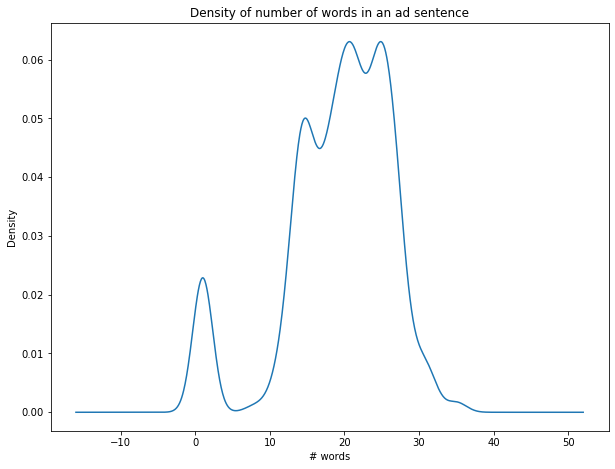

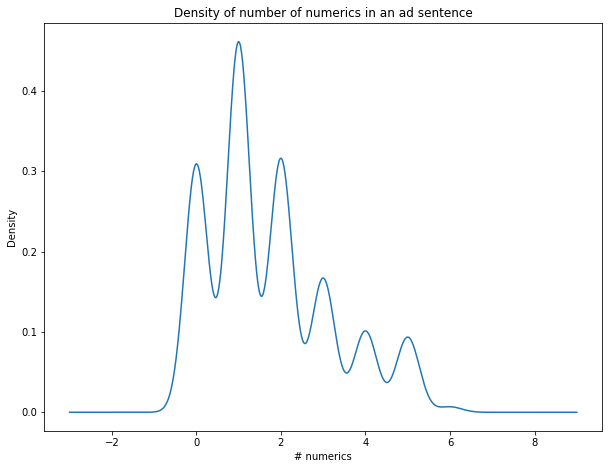

In [46]:
plt.figure()
plt.title("Density of number of words in an ad sentence")
plt.xlabel("# words")
causal_data_notext["body_len"].plot.kde()

plt.figure()
plt.title("Density of number of numerics in an ad sentence")
plt.xlabel("# numerics")
causal_data_notext["body_len_numbers"].plot.kde()

In [47]:
causal_data_notext["body_len_bin"] = pd.qcut(causal_data_notext['body_len'], q=2, labels=[False,True])

Ttest_indResult(statistic=3.6371654365107022, pvalue=0.00027890826293865974)
Class 1:  0.8408083435893724  Length:  2070
Class 0:  0.7399829795642294  Length:  2203


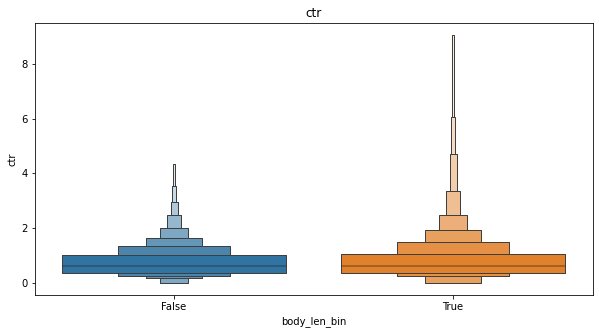

Ttest_indResult(statistic=-0.5694582434620907, pvalue=0.5690751478457524)
Class 1:  1.7194375748695647  Length:  2070
Class 0:  1.7434372234498414  Length:  2203


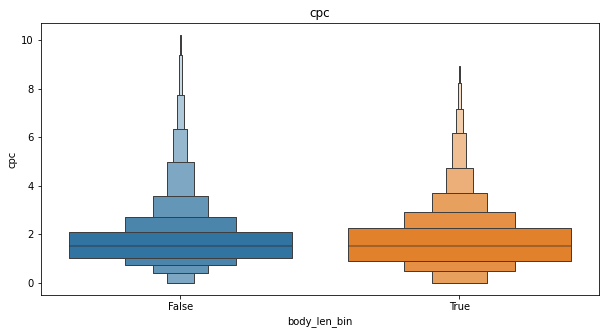

In [48]:
ttest_binary(causal_data_notext, "body_len_bin", "ctr")
ttest_binary(causal_data_notext, "body_len_bin", "cpc")

In [50]:
causal_data_notext["body_len_numbers_bin"] = causal_data_notext['body_len_numbers'].apply(lambda cnt:cnt > 1)

Ttest_indResult(statistic=-3.9547861671680056, pvalue=7.78443398417579e-05)
Class 1:  0.7307084419601984  Length:  2010
Class 0:  0.8404471086478125  Length:  2263


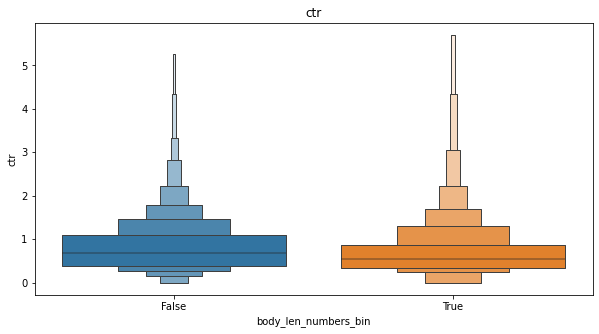

Ttest_indResult(statistic=3.7111759459745794, pvalue=0.00020892551742808632)
Class 1:  1.8146195492786048  Length:  2010
Class 0:  1.6582601366283711  Length:  2263


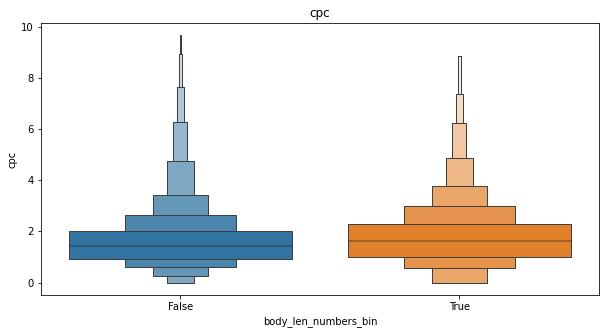

In [51]:
ttest_binary(causal_data_notext, "body_len_numbers_bin", "ctr")
ttest_binary(causal_data_notext, "body_len_numbers_bin", "cpc")

### having a code 

In [53]:
causal_data_notext["is_code"] = causal_data["Body"].apply(lambda sent: "code" in sent or "Code" in sent)

Ttest_indResult(statistic=-10.430040663905556, pvalue=3.618194905939216e-25)
Class 1:  0.6063972777476926  Length:  1625
Class 0:  0.9007780207213001  Length:  2648


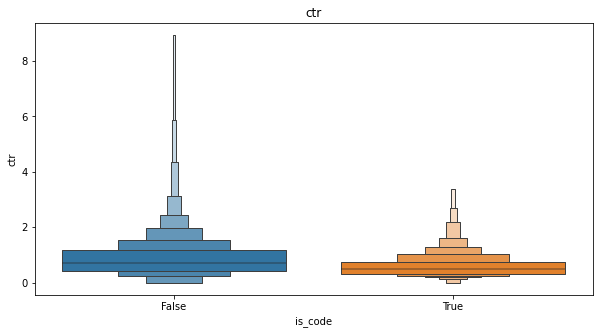

Ttest_indResult(statistic=15.396823210346104, pvalue=4.215779203229531e-52)
Class 1:  2.1347619426276943  Length:  1625
Class 0:  1.4845316565219024  Length:  2648


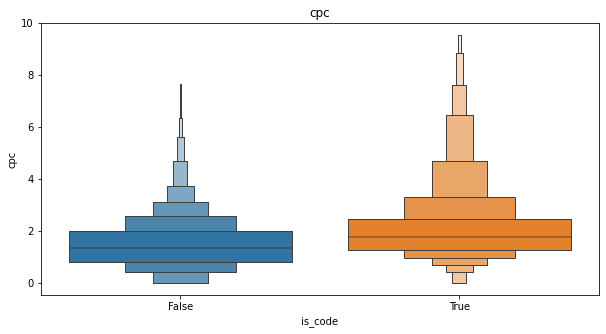

In [54]:
ttest_binary(causal_data_notext, "is_code", "ctr")
ttest_binary(causal_data_notext, "is_code", "cpc")

### domain words

In [55]:
ad_words = ["code","shipping","free","sale"]
domain_words = ["retinol","acne","spots","Serum","breakouts","Vita","clinically","Glycolic"]


In [56]:
def domain_detector(sent, domain_words):
    for dw in domain_words:
        if dw in sent:
            return True
    return False

In [57]:
domain_words = ["retinol","acne","spots","Serum","breakouts","Vita","clinically","Glycolic"]
causal_data_notext["is_domain"] = causal_data["Body"].apply(domain_detector, args = (domain_words,))

Ttest_indResult(statistic=1.4857529731669323, pvalue=0.13741827949139532)
Class 1:  0.8100482473674063  Length:  2074
Class 0:  0.7688111460527505  Length:  2199


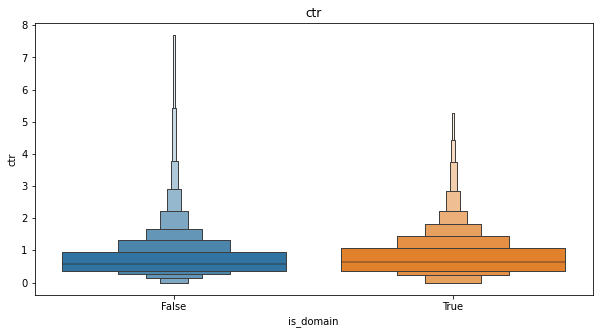

Ttest_indResult(statistic=-9.51558728164749, pvalue=2.930785180055494e-21)
Class 1:  1.5275866157425235  Length:  2074
Class 0:  1.9244262583856315  Length:  2199


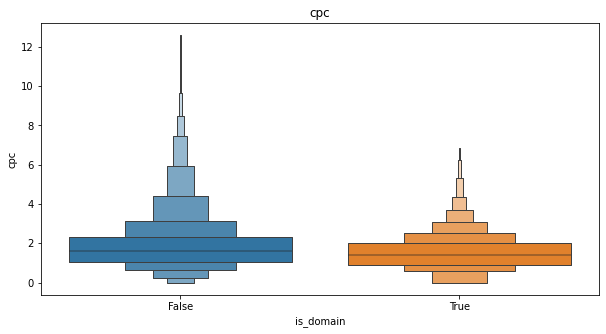

In [58]:
ttest_binary(causal_data_notext, "is_domain", "ctr")
ttest_binary(causal_data_notext, "is_domain", "cpc")

In [ ]:
### end of structure

In [ ]:
### random analytics

In [ ]:
import re
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [ ]:
causal_data["Body"] = causal_data["Body"].apply(convert_nans)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = causal_data["Body"].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

In [ ]:
X.shape

In [ ]:
X

In [ ]:
zen = " ".join(causal_data["Body"].tolist())

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')

In [ ]:
zen_no_punc = tokenizer.tokenize(zen)

In [ ]:
len(causal_data["Body"])

In [ ]:
u,c = np.unique(zen_no_punc,return_counts=True)
uc = dict(zip(u,c))
sorted(uc.items(), key=lambda a:-a[1])

In [ ]:
# tf-idf based approach
# topic modeling
# word clustering based on embedding

In [ ]:
word_count_dict = Counter(w.title() for w in zen_no_punc if w.lower() not in stopwords.words())
word_count_dict.most_common()

## Images

In [ ]:
- presence of a human in the video
- color spectrum and performance
- 

## Snapshot of data

In [ ]:
ad_data['start_date'] = pd.to_datetime(ad_data['Starts'], format='%Y-%m-%d')
ad_data['start_month_yr'] = ad_data['start_date'].dt.to_period('M')
ad_data['start_month'] = ad_data['start_date'].dt.month
ad_data['start_yr'] = ad_data['start_date'].dt.year

In [ ]:
sns.countplot(x="start_yr", data=ad_data)
plt.title("Number of ads by year")
plt.xticks(rotation=90)
plt.show()

In [ ]:
yearly_spending = ad_data['Amount Spent (USD)'].groupby(ad_data['start_yr']).sum()
df = pd.DataFrame({'Year': yearly_spending.index, 'Amount Spent (USD)': yearly_spending.values})
sns.barplot(x = 'Year', y = 'Amount Spent (USD)', data = df)
plt.title("Total Spending (USD): " + str(round(np.sum(ad_data['Amount Spent (USD)']),2)))
plt.show()

## some feature analysis

### clean up features

In [ ]:
def replace_nans(name):
    """
    for a given column - interpret nan as absent and anything else as present
    
    """
    
    return str(name) != "nan"
    
# deprecated
def process_ad_name(name):
    return name.split('_')[-1]


def get_media_type(name,im,vid):
    if "Video" in name:
        return "Video"
    elif "Static" in name:
        return "Image"
    elif "GIF" in name:
        return "GIF"
    else:
        if str(im) != "nan":
            return "Image"
        elif str(vid) != "nan":
            return "Video"
        else:
            return "UNK"
    
# targeting column

def target_subsetter(gender,age):
    # says ad is targetted if gender is women and min age is 24
    if gender == "Women" and age == 24:
        return 1
    else:
        return 0

In [ ]:
ad_data['messenger_ad'] = ad_data['Messenger Positions'].apply(replace_nans)

In [ ]:
# apply naive processing
ad_data['media_type'] = ad_data['Ad Name_x'].apply(process_ad_name)

In [ ]:
# get media type from a combo of ad name, image hash and video url
ad_data["media_type"] = ad_data.apply(lambda x: get_media_type(x['Ad Name_x'], x['Image Hash'], x['Video Thumbnail URL']), axis=1)

### metrics exploration

In [ ]:
ad_data['ctr'] = ad_data['CTR (All)']
ad_data['cpc'] = ad_data['CPC (All) (USD)']
ad_data['roas'] = ad_data['Website Purchase ROAS (Return on Ad Spend)']
# transform to log scale
epsilon = 10e-2
ad_data['log_ctr'] = np.log(np.where(ad_data['ctr'] == 0, epsilon, ad_data['ctr']))
ad_data['log_cpc'] = np.log(np.where(ad_data['cpc'] == 0, epsilon, ad_data['cpc'])) 

In [ ]:
ad_data[metric_cols].describe()

In [ ]:
sns.kdeplot(data=ad_data, x="ctr")
plt.title('CTR (All)')
plt.axvline(x=np.mean(ad_data.ctr), label = "mean", color = "red", alpha = 0.75)
plt.axvline(x=np.median(ad_data.ctr), label = "median", color = "green", alpha = 0.75)
plt.xticks(np.arange(0, np.max(ad_data.ctr), 1.0))
plt.legend()
plt.show()

In [ ]:
sns.kdeplot(data=ad_data, x="cpc")
plt.title('CPC (All) (USD)')
plt.axvline(x=np.mean(ad_data.cpc), label = "mean", color = "red", alpha = 0.75)
plt.axvline(x=np.median(ad_data.cpc), label = "median", color = "green", alpha = 0.75)
plt.xticks(np.arange(0, np.max(ad_data.cpc), 5.0))
plt.legend()
plt.show()

In [ ]:
sns.kdeplot(data=ad_data[ad_data.roas.notna()], x='roas')
plt.title('Website Purchase ROAS (Return on Ad Spend)')
plt.axvline(x=np.mean(ad_data.roas), label = "mean", color = "red", alpha = 0.75)
plt.axvline(x=np.median(ad_data.roas), label = "median", color = "green", alpha = 0.75)
plt.xticks(np.arange(0, np.max(ad_data.roas), 5000))
plt.legend()
plt.show()

## media exploration

In [ ]:
df_media = ad_data[['log_cpc', 'cpc', 'log_ctr', 'ctr', "media_type"]]
df_media.media_type.value_counts()

In [ ]:
X_bin = pd.get_dummies(df_media.media_type, columns=["media_type"])[['Video', 'GIF']]

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(x='media_type', y='ctr', data=df_media, showfliers=False)
ax.set_title('CTR')
plt.show()

In [ ]:
ctr = df_media.ctr
model_ctr = sm.OLS(ctr, X_bin).fit()
model_ctr.summary()

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.boxenplot(x='media_type', y='cpc', data=df_media, showfliers=True)
ax.set_title('CPC')
plt.show()

In [ ]:
cpc = df_media.cpc
model_cpc = sm.OLS(cpc, X_bin).fit()
model_cpc.summary()